## Lighthouse Labs - Synaptive Medical
### Introduction to Machine Learning
### W3D1 part 2 Classification Models: Logistic Regression and Random Forests

Instructor: Socorro Dominguez  
December 04, 2020


**Agenda:**
1. Regression problems Vs. classification problems



2. Logistic regression
   * Uses of logistic regression
   * Why is it called regression?



3. Tree Based Algorithms
    * Decision Trees
    * Random Forests


In [1]:
import graphviz
from sklearn.tree import export_graphviz
from display_tree import display_tree

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_tree(X, y, model, predict_proba = False):
    
    # Join data for plotting
    sample = (X.join(y))
    # Create a mesh for plotting
    step = (X.max() - X.min()) / 50
    x1, x2 = np.meshgrid(np.arange(sample.min()[0]-step[0], sample.max()[0]+step[0], step[0]),
                         np.arange(sample.min()[1]-step[1], sample.max()[1]+step[1], step[1]))

    # Store mesh in dataframe
    mesh_df = pd.DataFrame(np.c_[x1.ravel(), x2.ravel()], columns=['x1', 'x2'])

    # Mesh predictions
    if predict_proba:
        mesh_df['predictions'] = model.predict_proba(mesh_df[['x1', 'x2']])[:, 0]
        # Plot
        base_plot = alt.Chart(mesh_df).mark_rect(opacity=0.5).encode(
            x=alt.X('x1', bin=alt.Bin(step=step[0])),
            y=alt.Y('x2', bin=alt.Bin(step=step[1])),
            color=alt.Color('predictions', title='P(blue)', scale=alt.Scale(scheme='redblue'))
        ).properties(
            width=400,
            height=400
        )
        return alt.layer(base_plot).configure_axis(
            labelFontSize=20,
            titleFontSize=20
        ).configure_legend(
            titleFontSize=20,
            labelFontSize=20
        )
    else:
        mesh_df['predictions'] = model.predict(mesh_df[['x1', 'x2']])
        # Plot
        scat_plot = alt.Chart(sample).mark_circle(
            stroke='black',
            opacity=1,
            strokeWidth=1.5,
            size=100
        ).encode(
            x=alt.X(X.columns[0], axis=alt.Axis(labels=True, ticks=True, title=X.columns[0])),
            y=alt.Y(X.columns[1], axis=alt.Axis(labels=True, ticks=True, title=X.columns[1])),
            color=alt.Color(y.columns[0])
        )
        base_plot = alt.Chart(mesh_df).mark_rect(opacity=0.5).encode(
            x=alt.X('x1', bin=alt.Bin(step=step[0])),
            y=alt.Y('x2', bin=alt.Bin(step=step[1])),
            color=alt.Color('predictions', title='Legend')
        ).properties(
            width=400,
            height=400
        )
        return alt.layer(base_plot, scat_plot).configure_axis(
            labelFontSize=20,
            titleFontSize=20
        ).configure_legend(
            titleFontSize=20,
            labelFontSize=20
        )

## Trees

A decision tree is an acyclic graph that can be used to make decisions. In each branching node of the graph, a specific feature is examined. If the value of the feature is below a specific threshold, then the left branch is followed; otherwise, the right branch is followed. 
As the leaf node is reached, the decision is made about the class to which the example belongs.

**Decision Tree Building**
- Get our data in
- Train / validation split
- Fit a **classification tree**

**Case study:** Suppose you have three different job offers with comparable salaries and job descriptions. You want to decide which one to accept, and you want to make this decision based on which job is likely to make you happy. Being a very systematic person, you come up with three features associated with the offers, which are important for your happiness: whether the colleagues are supportive, work-hour flexibility, and whether the company is a start-up or not.

In [55]:
offer_data = {
    # Features
    "supportive_colleagues": [1, 0, 0],
    "work_hour_flexibility": [0, 0, 1],
    "start_up": [0, 1, 1],
    # Target
    "target": ["?", "?", "?"],
}

offer_df = pd.DataFrame(offer_data)
offer_df

,supportive_colleagues,work_hour_flexibility,start_up,target
0,1,0,0,?
1,0,0,1,?
2,0,1,1,?


Next, you ask the following questions to some of your friends (who you think have similar notions of happiness) regarding their jobs:

Do you have supportive colleagues? (1 for 'yes' and 0 for 'no')
Do you have flexible work hours? (1 for 'yes' and 0 for 'no')
Do you work for a start-up? (1 for 'start up' and 0 for 'non start up')
Are you happy in your job? (happy or unhappy)
You get the following data from this toy survey. Your goal is to train a machine learning model using this toy data and then use this model to predict which job is likely to make you happy.

In [49]:
happiness_data = {
    # Features
    "supportive_colleagues": [1, 1, 1, 0, 0, 1, 1, 0, 1, 0],
    "work_hour_flexibility": [1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
    "start_up": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
    # Target
    "target": [
        "happy",
        "happy",
        "happy",
        "unhappy",
        "unhappy",
        "happy",
        "happy",
        "unhappy",
        "unhappy",
        "unhappy",
    ],
}

train_df = pd.DataFrame(happiness_data)
train_df

,supportive_colleagues,work_hour_flexibility,start_up,target
0,1,1,1,happy
1,1,1,0,happy
2,1,0,1,happy
3,0,1,0,unhappy
4,0,1,1,unhappy
5,1,0,0,happy
6,1,1,0,happy
7,0,0,1,unhappy
8,1,0,1,unhappy
9,0,0,0,unhappy


The idea of a machine learning algorithm is to fit the best model on the given training data, which is in the form of feature vectors (X) and their corresponding targets(y), and then using this model to predict targets for new examples (represented with feature vectors).

From train_df, create the feature table and save it in an object named X and the target in an object named y.

In [50]:
X = train_df.drop(columns=["target"])
y = train_df["target"]

In [51]:
toy_tree = None

### BEGIN SOLUTION
# instantiate a class of the DecisionTreeClassifier
toy_tree = DecisionTreeClassifier()
# fit the model to the data. The semicolon at the end is used to suppress displaying the output of model.fit
toy_tree.fit(X, y)
### END SOLUTION

DecisionTreeClassifier()

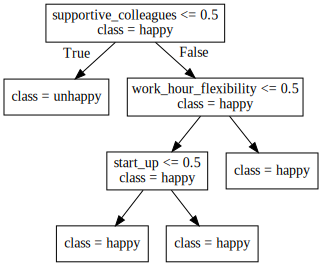

In [52]:
toy_displayed = None
### BEGIN SOLUTION
toy_displayed = display_tree(X.columns, toy_tree)
toy_displayed

In [53]:
predicted_train = None

### BEGIN SOLUTION
predicted_train = train_df.assign(predicted = toy_tree.predict(X))
predicted_train

,supportive_colleagues,work_hour_flexibility,start_up,target,predicted
0,1,1,1,happy,happy
1,1,1,0,happy,happy
2,1,0,1,happy,happy
3,0,1,0,unhappy,unhappy
4,0,1,1,unhappy,unhappy
5,1,0,0,happy,happy
6,1,1,0,happy,happy
7,0,0,1,unhappy,unhappy
8,1,0,1,unhappy,happy
9,0,0,0,unhappy,unhappy


In [56]:
offer_X = offer_df.drop(columns=["target"])

pred_offer_df = offer_df.assign(predicted = toy_tree.predict(offer_X))
pred_offer_df

,supportive_colleagues,work_hour_flexibility,start_up,target,predicted
0,1,0,0,?,happy
1,0,0,1,?,unhappy
2,0,1,1,?,unhappy


## What did the classification tree do?
- Found a good way to split and repeat

## So how do we decide the split?
- Basic idea is to pick a criterion (see [here](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)) and then minimize it across possible splits.
- Common one is Gini impurity

### Gini Impurity

<img src='imgs/gini.png' width=300>

- $C$ is number of classes in target variable
- $p$ is proportion of class $i$ in a group
- tells us what is the probability of misclassifying an observation --> lower the better


Full details here: https://towardsdatascience.com/gini-impurity-measure-dbd3878ead33

## Decision trees, pros and cons
### Advantages:
- Simple to understand and to interpret. Trees can be visualised.
- Requires little data preparation. Doesn't require data normalisation.
- Can handle multi-class classification well.

### Disadvantages:
- Tendency to overfit with overly complex trees that don't generalize well; pruning techniques (e.g., minimum number of samples required at a leaf node, maximum depth of tree) is needed to avoid the problem
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated; mitigated through ensembles (more on this soon)
- Is a "greedy" algorithm. Each node is only locally optimal which cannot gaurantee globally optimal tree

## Random Forests

### General idea:
   - `fit` a diverse set of classifiers by **injecting randomness** in the classifier construction
   - `predict` by taking the average of predictions given by individual classifiers

### How do we inject randomness in the classifier construction? 
   1. Data: Build each tree on a bootstrap sample (i.e., a sample drawn **with replacement** from the training set)
   2. Features: Consider a random subset of features at each split (`RandomForestClassifier`)
        
**The intuition here is the wisdom of crowds**

## The random forest classifier 

- Create a collection (ensemble) of trees. Grow each tree on an independent bootstrap sample from the data.
- At each node:
    - Randomly select a subset of features out of all features (independently for each node)
    - Find the best split on the selected features
    - Grow the trees to maximum depth
- Vote between the trees to get predictions for new data

## Random Forest Training
- Showing feature subset

<img src='imgs/random-forest-features.jpg'>

## Random Forest Prediction
<img src='imgs/random-forest-predict.jpg'>

## Beating the fundamental tradeoff...

- Decreasing training error and not increasing approximation error.
- This is the promise of ensembles, though it's not guaranteed

## Random Forests summary

- Accuracy
    - Usually more accurate compared to decision trees, usually one of the best performing off-the-shelf classifiers
- Speed
    - Slower than decision trees because we are fitting multiple trees 
    - But can easily parallelize training because all trees are independent of each other 
- Overfitting
    - No depth limit decision tree tends to overfit 
    - Random forests are less likely to overfit
- Interpretability
    - Decision trees are more interpretable (can still use `feature_importance` function)

In [18]:
from sklearn.model_selection import train_test_split 
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, roc_auc_score
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier 

# Other
import numpy as np
import pandas as pd
import pickle 
from sklearn import datasets
from plot_classifier import plot_classifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [20]:
import plotly.io as pio # conda install -c plotly plotly-orca
from IPython.display import Image

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Logistic Regression

The first thing to say is that logistic regression is not a regression, but a classification learning algorithm. The name comes from statistics and is due to the fact that the mathematical formulation of logistic regression is similar to that of linear regression.

### Limitations for Linear Regression

In Regression, we allow the response to take on any real number. But what if the range is restricted?

1. Positive values: river flow. 
    - Lower limit: 0
2. Percent/proportion data: proportion of income spent on housing in Vancouver. 
    - Lower limit: 0
    - Upper limit: 1. 
3. Binary data: success/failure data.
    - Only take values of 0 and 1.
4. Count data: number of male crabs nearby a nesting female
    - Only take count values (0, 1, 2, ...)

How can we fit a regression curve to stay within the bounds of the data, while still retaining the interpretability that we have with a linear model function?

### Link Functions

We can transform the model function. 

**Logistic Regression** It is a special case of **linear regression** where the target variable is categorical in nature. It uses a log of odds as the dependent variable. Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit function.

- $\text{logit}(x)=\log(\frac{x}{(1+e^{-(\beta_0+\beta_iX_i)})})$

for binary response values.

- Parameter interpretation: an increase of one unit in the predictor is associated with an $\exp(\beta)$ times increase in the odds of "success", where $\beta$ is the slope parameter, and odds is the ratio of success to failure probabilities.



Linear Regression's answer is based on Least Squared Squares. For fitting the best model in Logistic Regression,  **Maximum Likelihood Estimation** is used. 

Maximizing the likelihood function helps find the parameters that are most likely to produce the observed data. MLE sets the mean and variance as parameters and helps us find  the specific parametric values for a given model. This set of parameters can be used for predicting the data needed in a normal distribution.

The logistic function gives an ‘Sigmoid’ shaped curve that can take any real-valued number and map it into a value between 0 and 1. 

If the curve goes to positive infinity, the model will predict 1.
If the model goes to negative infinity, the model will predict 0.

If the output of the sigmoid function is more than 0.5, we usually classify the outcome as 1 otherwise, as 0. We can change this threshold.

We can say that the Sigmoid Function is a special case of the Softmax function when we only have two classes. - More later but very important for NN-

*You can check more about this (Odds and Log of Odss in the additional bonus slides)*

### Why people use linear classifiers

Logistic regression are used EVERYWHERE!

- Fast training and testing.
  - Training on huge datasets.
  - Testing is just computing $w^Tx_i$.
- Weights $w_j$ are easy to understand. INTERPRETABILITY
  - It's how much $x_j$ changes the prediction and in what direction.
- We can often get a good test error.
  - With many features.
- Smoother predictions than random forests.

Bonus Slides

## GLM's (Generalized Linear Models)

Since Logistic Regression has class 1s and 0s it is a binomial distribution and not a Normal Distribution

GLM's use a link function to connect the linear model to a model that predicts for non normal distribution. As we saw earlier, our link function was the Sigmoid Function.

Generalized Linear Model (GLM) is a generalization of ordinary linear regression that allows for response variables that have error distribution models other than a normal distribution. (Counts of male crabs around a nesting female?)

When you fit a GLM, you already have the information needed to produce a probabilistic forecast. This is because, in addition to specifying the relationship between the predictors and the mean, we also specify a distribution of the response (such as Poisson, Bernoulli, or Gaussian).

You will do a small exercise today on this. And it will be clearer.

Unfortunately, the implementations are better seen in R or using statsmodel library in Python.

### Odds

The **probability** that an event will occur is the fraction of times you expect to see that event in many trials. 
Probabilities always range between 0 and 1. 

The **odds** are defined as the probability that the event will occur divided by the probability that the event will not occur.  
$\frac{y}{(1-y)}$

* If a race horse runs 100 races and wins 25 times and loses the other 75 times, the probability of winning is 25/100 = 0.25 or 25%. The odds of the horse winning are 25/75 = 0.333 or 1 win to 3 loses.

* If the horse runs 100 races and wins 5 and loses the other 95 times, the probability of winning is 0.05 or 5%, and the odds of the horse winning are 5/95 = 0.0526.

* If the horse runs 100 races and wins 50, the probability of winning is 50/100 = 0.50 or 50%, and the odds of winning are 50/50 = 1 (even odds).

* If the horse runs 100 races and wins 80, the probability of winning is 80/100 = 0.80 or 80%, and the odds of winning are 80/20 = 4 to 1.

What would happen if the horse is too bad at racing? What would happen if the horse is the best? 

If the horse is too bad, the odds of winning will tend to zero.

But if the horse is too good, the odds of winning will be too high.... they can reach infinity... 

How can we compare?

**Log Odds**  
So now that we understand Odds and Probability, we can understand Log Odds. 

Log of Odds is nothing but log(odds). Log Odds makes the magnitude of odds against look so much smaller to those in favor.

When we take a log of odds, we make it look symmetrical.

$Logit Function = log\frac{p}{1-p}$

Odds of winning = 4/6 = 0.6666  
log(Odds of winning) = log(0.6666) = -0.176  
Odds of losing = 6/4 = 1.5  
log(Odds of losing) = log(1.5) = 0.176  

The value of the logit function heads towards infinity as p approaches 1 and towards negative infinity as it approaches 0.

The logit function is useful in analytics because it maps probabilities (which are values in the range [0, 1]) to the full range of real numbers. In particular, if you are working with “yes-no” (binary) inputs it can be useful to transform them into real-valued quantities prior to modeling. This is essentially what happens in logistic regression.

The inverse of the logit function is the sigmoid function. That is, if you have a probability p, sigmoid(logit(p)) = p. The sigmoid function maps arbitrary real values back to the range [0, 1]. 

The larger the value, the closer to 1 you’ll get.

The formula for the sigmoid function is $\sigma(x) = \frac{1}{(1 + exp^{-x})}$ . 

Here is a plot of the function:

![sigmoid](imgs/sigmoid.png)

The sigmoid function is what we associate as the Logistic Regression. The sigmoid might be useful if you want to transform a real valued variable into something that represents a probability. This sometimes happens at the end of a classification process. 

There are other functions that map probabilities to reals (and vice-versa), so what is special about the logit and sigmoid? 
- The logit function has the nice connection to odds described at the beginning. Even if we associate LogReg with the squiggly line, we CANNOT forget that the COEFFICIENTS ARE presented in terms of the log(odds) graph.

- Gradients of the logit and sigmoid are simple to calculate. Many optimization and ML techniques use gradients.

The biggest drawback of the sigmoid function is the so-called “vanishing gradient” problem (the gradient is vanishingly small, preventing the weight from changing its value).